# **Content-based Course Recommender System using Course Similarities**


## Objectives


* Obtain the similarity between courses from a course similarity matrix
* Use the course similarity matrix to find and recommend new courses which are similar to enrolled courses


----


## Prepare and setup lab environment


Let's first install and import the required libraries:


In [1]:
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

In [2]:
# also set a random state
rs = 45

Next, let's load a pre-made course similarity matrix. If you are interested, you could easily calculate such a similarity matrix by iterating through all possible course pairs and calculating their similarities.


In [3]:
sim_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/sim.csv"

In [4]:
sim_df = pd.read_csv(sim_url)
sim_df

,0,1,2,3,4,5,6,7,8,9,...,297,298,299,300,301,302,303,304,305,306
0,1.000000,0.088889,0.088475,0.065556,0.048810,0.104685,0.065202,0.143346,0.000000,0.024405,...,0.012695,0.070225,0.058224,0.046610,0.025850,0.033944,0.076825,0.072898,0.039276,0.121113
1,0.088889,1.000000,0.055202,0.057264,0.012182,0.078379,0.032545,0.119251,0.044162,0.000000,...,0.180593,0.124631,0.087187,0.093060,0.019354,0.028239,0.063911,0.138270,0.031367,0.076940
2,0.088475,0.055202,1.000000,0.026463,0.039406,0.000000,0.000000,0.154303,0.000000,0.000000,...,0.040996,0.037796,0.013430,0.037630,0.000000,0.018270,0.082698,0.133400,0.012684,0.000000
3,0.065556,0.057264,0.026463,1.000000,0.000000,0.250490,0.390038,0.000000,0.000000,0.000000,...,0.151882,0.420084,0.427908,0.055764,0.000000,0.094759,0.030638,0.017443,0.018796,0.158073
4,0.048810,0.012182,0.039406,0.000000,1.000000,0.000000,0.000000,0.085126,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.096877,0.000000,0.060474,0.030415,0.129871,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,0.033944,0.028239,0.018270,0.094759,0.060474,0.064851,0.053856,0.039467,0.036539,0.060474,...,0.047186,0.116008,0.137406,0.211743,0.256220,1.000000,0.211520,0.168595,0.129766,0.263734
303,0.076825,0.063911,0.082698,0.030638,0.030415,0.000000,0.000000,0.119098,0.055132,0.045622,...,0.177989,0.092381,0.145126,0.527636,0.249675,0.211520,1.000000,0.242269,0.416067,0.178384
304,0.072898,0.138270,0.133400,0.017443,0.129871,0.009285,0.000000,0.254274,0.094165,0.025974,...,0.153128,0.105191,0.138692,0.281108,0.132977,0.168595,0.242269,1.000000,0.220159,0.128902
305,0.039276,0.031367,0.012684,0.018796,0.000000,0.015008,0.024926,0.082199,0.076102,0.055978,...,0.149234,0.093962,0.162170,0.476644,0.222350,0.129766,0.416067,0.220159,1.000000,0.126274


The similarity matrix is a real number, symmetric metric with each element representing the similarity value (ranged 0 to 1) between course index `i` and course index `j`. 


We could use `seaborn` to visualize the similarity metric, and since it is symmetric, we can just show the triangular  matrix (lower left):


<Axes: >

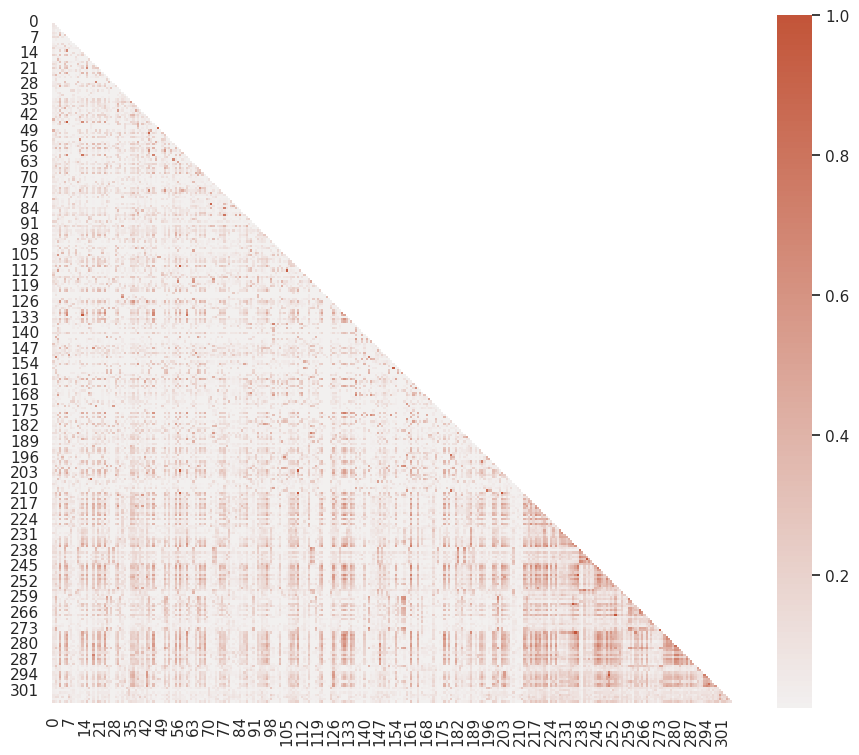

In [5]:
# Configure seaborn
sb.set_theme(style="white")
mask = np.triu(np.ones_like(sim_df, dtype=bool))
_, ax = plt.subplots(figsize=(11, 9))
cmap = sb.diverging_palette(230, 20, as_cmap=True)
# Plot a similarity heat map
sb.heatmap(sim_df, mask=mask, cmap=cmap, vmin=0.01, vmax=1, center=0,
            square=True)

As we can see from the heatmap; there are many hot spots, which means many courses are similar to each other. Such patterns suggest that it is possible to build a recommender system based on course similarities. 


Let's take a look at a quick example:


In [6]:
# Let's first load the course content and BoW dataset
course_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/course_processed.csv"
course_df = pd.read_csv(course_url)
bow_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/courses_bows.csv"
bow_df = pd.read_csv(bow_url)

In [7]:
bow_df.head()

,doc_index,doc_id,token,bow
0,0,ML0201EN,ai,2
1,0,ML0201EN,apps,2
2,0,ML0201EN,build,2
3,0,ML0201EN,cloud,1
4,0,ML0201EN,coming,1


First, we want to mention that the matrix indices are course indices (such as `0, 1, 2, 3`). Very often we need to query the actual course ids (such as `ML0151EN` and `ML0101ENv3`) based on course indices and vice versa. We can save the course id's and indices into two dictionaries for late queries:


Then, based on the `doc_index` and `doc_id` columns, we create an index to id mapping and another id to index mapping in two Python dictionaries:


In [8]:
# Create course id to index and index to id mappings
def get_doc_dicts(bow_df):
    grouped_df = bow_df.groupby(['doc_index', 'doc_id']).max().reset_index(drop=False)
    idx_id_dict = grouped_df[['doc_id']].to_dict()['doc_id']
    id_idx_dict = {v: k for k, v in idx_id_dict.items()}
    del grouped_df
    return idx_id_dict, id_idx_dict

Now suppose we have two example courses:


In [9]:
course1 = course_df[course_df['COURSE_ID'] == "ML0151EN"]
course1

,COURSE_ID,TITLE,DESCRIPTION
200,ML0151EN,machine learning with r,this machine learning with r course dives into...


In [10]:
course2 = course_df[course_df['COURSE_ID'] == "ML0101ENv3"]
course2

,COURSE_ID,TITLE,DESCRIPTION
158,ML0101ENv3,machine learning with python,machine learning can be an incredibly benefici...


From their titles we can see they are all about machine learning. As such, they should be very similar to each other. Let's try to find their similarity in the similarity matrix.

With their course ids, we can use the `id_idx_dict` dictionary to query their row and column index on the similarity matrix:


In [11]:
idx_id_dict, id_idx_dict = get_doc_dicts(bow_df)
idx1 = id_idx_dict["ML0151EN"]
idx2 = id_idx_dict["ML0101ENv3"]
print(f"Course 1's index is {idx1} and Course 2's index is {idx2}")

Course 1's index is 200 and Course 2's index is 158


Then we can locate their similarity value in row 200 and col 158, `sim_matrix[200][158]`:


In [82]:
id_idx_dict['ML0201EN']

0

In [83]:
idx_id_dict[0]

'ML0201EN'

In [13]:
sim_matrix = sim_df.to_numpy()

In [14]:
sim = sim_matrix[idx1][idx2]
sim

0.6626221399549089

It's about 66% meaning these two courses are quite similar to each other.


### Find courses which are similar enough to your enrolled courses.


Now you know how to easily use the pre-computed similarity matrix to query the similarity between any two courses. Do you want to make some course recommendations for yourself?

Let's assume you are an end-user of the online course platform and already audited or completed some courses previously. Next, you expect the system would recommend similar courses based on your enrollments history.


From the full course list, choose any courses that may interest you, such as those machine learning related courses:


In [15]:
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)
course_df[['COURSE_ID', 'TITLE']]

,COURSE_ID,TITLE
0,ML0201EN,robots are coming build iot apps with watson swift and node red
1,ML0122EN,accelerating deep learning with gpu
2,GPXX0ZG0EN,consuming restful services using the reactive jax rs client
3,RP0105EN,analyzing big data in r using apache spark
4,GPXX0Z2PEN,containerizing packaging and running a spring boot application
5,CNSC02EN,cloud native security conference data security
6,DX0106EN,data science bootcamp with r for university proffesors
7,GPXX0FTCEN,learn how to use docker containers for iterative development
8,RAVSCTEST1,scorm test 1
9,GPXX06RFEN,create your first mongodb database


In [23]:
# Reset pandas settings
pd.reset_option('display.max_rows')
pd.reset_option('max_colwidth')

In [24]:
enrolled_course_ids = ["excourse93","excourse69","excourse68","excourse92","GPXX05RDEN"] # add your interested coures id to the list

In [25]:
enrolled_courses = course_df[course_df['COURSE_ID'].isin(enrolled_course_ids)]
enrolled_courses

,COURSE_ID,TITLE,DESCRIPTION
192,GPXX05RDEN,medical appointment data analysis,in this notebook we will try to analyze why wo...
281,excourse68,big data modeling and management systems,once you ve identified a big data issue to ana...
282,excourse69,machine learning with big data,want to make sense of the volumes of data you ...
305,excourse92,introduction to web development,this course is designed to start you on a path...
306,excourse93,interactivity with javascript and jquery,this course is the third in our javascript for...


Given the full course list, we can find those unselected courses:


In [26]:
all_courses = set(course_df['COURSE_ID'])

In [27]:
unselected_course_ids = all_courses.difference(enrolled_course_ids)
unselected_course_ids

{'AI0111EN',
 'BC0101EN',
 'BC0201EN',
 'BC0202EN',
 'BD0101EN',
 'BD0111EN',
 'BD0115EN',
 'BD0121EN',
 'BD0123EN',
 'BD0131EN',
 'BD0133EN',
 'BD0135EN',
 'BD0137EN',
 'BD0141EN',
 'BD0143EN',
 'BD0145EN',
 'BD0151EN',
 'BD0153EN',
 'BD0211EN',
 'BD0212EN',
 'BD0221EN',
 'BD0223EN',
 'BENTEST4',
 'CB0101EN',
 'CB0103EN',
 'CB0105ENv1',
 'CB0201EN',
 'CC0101EN',
 'CC0103EN',
 'CC0120EN',
 'CC0121EN',
 'CC0150EN',
 'CC0201EN',
 'CC0210EN',
 'CC0250EN',
 'CC0271EN',
 'CL0101EN',
 'CNSC02EN',
 'CO0101EN',
 'CO0193EN',
 'CO0201EN',
 'CO0301EN',
 'CO0302EN',
 'CO0401EN',
 'COM001EN',
 'CP0101EN',
 'DA0101EN',
 'DA0151EN',
 'DA0201EN',
 'DAI101EN',
 'DB0101EN',
 'DB0111EN',
 'DB0113EN',
 'DB0115EN',
 'DB0151EN',
 'DE0205EN',
 'DJ0101EN',
 'DP0101EN',
 'DS0101EN',
 'DS0103EN',
 'DS0105EN',
 'DS0107',
 'DS0110EN',
 'DS0132EN',
 'DS0201EN',
 'DS0301EN',
 'DS0321EN',
 'DV0101EN',
 'DV0151EN',
 'DW0101EN',
 'DX0106EN',
 'DX0107EN',
 'DX0108EN',
 'EE0101EN',
 'GPXX01AVEN',
 'GPXX01DCEN',
 'GPXX01

Now, you can iterate each unselect course and check if it is similar enough to any of your selected courses. If the similarity is larger than a threshold such as 0.5 or 0.6, then add it to your course recommendation list:


In [28]:
def generate_recommendations_for_one_user(enrolled_course_ids, unselected_course_ids, id_idx_dict, sim_matrix):
    # Create a dictionary to store your recommendation results
    res = {}
    threshold = 0.6 
    for enrolled_course in enrolled_course_ids:
        for unselect_course in unselected_course_ids:
            if enrolled_course in id_idx_dict and unselect_course in id_idx_dict:
                
                sim = 0
                # Find the two indices for each enrolled_course and unselect_course, based on their two ids
                # Calculate the similarity between an enrolled_course and an unselect_course
                # e.g., Course ML0151EN's index is 200 and Course ML0101ENv3's index is 158
                idx1 = id_idx_dict[enrolled_course]
                idx2 = id_idx_dict[unselect_course]
                
                # Find the similarity value from the sim_matrix
                #sim = sim_matrix[200][158]
                sim = sim_matrix[idx1][idx2]
                
                if sim > threshold:
                    if unselect_course not in res:
                        res[unselect_course] = sim
                    else:
                        if sim >= res[unselect_course]:
                            res[unselect_course] = sim
                            
    # Sort the results by similarity
    res = {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse=True)}
    return res
generate_recommendations_for_one_user(enrolled_course_ids,unselected_course_ids,id_idx_dict,sim_matrix)

{'excourse67': 0.8162431524411258,
 'excourse32': 0.7463307735294326,
 'excourse72': 0.7239396564289607,
 'excourse74': 0.7156183028096771,
 'DS0110EN': 0.6528639873857345,
 'excourse23': 0.6470742121049355,
 'excourse36': 0.6470742121049355,
 'excourse04': 0.6450662226406081,
 'excourse09': 0.6420363048520354,
 'excourse33': 0.6278035386521185,
 'excourse70': 0.6233858933462867,
 'BD0101EN': 0.616759399492821,
 'excourse02': 0.6122241715654336}

The completed `generate_recommendations_user(...)` may ouput a dictionary like this:


{'ML0151EN': 0.6626221399549089,
 'excourse47': 0.6347547807096177,
 'excourse46': 0.6120541193300345}


###  Generate course recommendations based on course similarities for all test uesrs


In [29]:
test_users_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/rs_content_test.csv"
test_users_df = pd.read_csv(test_users_url)

Let's look at how many test users we have in the dataset.


In [30]:
test_users = test_users_df.groupby(['user']).max().reset_index(drop=False)
test_user_ids = test_users['user'].to_list()
print(f"Total numbers of test users {len(test_user_ids)}")

Total numbers of test users 1000


In [31]:
test_users_df

,user,item,rating
0,1502801,RP0105EN,3.0
1,1609720,CNSC02EN,2.0
2,1347188,CO0301EN,3.0
3,755067,ML0103EN,3.0
4,538595,BD0115EN,3.0
...,...,...,...
9397,1385217,EE0101EN,3.0
9398,1864644,DA0101EN,3.0
9399,435858,TMP0105EN,3.0
9400,1888188,DB0101EN,3.0


In [32]:
course_df

,COURSE_ID,TITLE,DESCRIPTION
0,ML0201EN,robots are coming build iot apps with watson ...,have fun with iot and learn along the way if ...
1,ML0122EN,accelerating deep learning with gpu,training complex deep learning models with lar...
2,GPXX0ZG0EN,consuming restful services using the reactive ...,learn how to use a reactive jax rs client to a...
3,RP0105EN,analyzing big data in r using apache spark,apache spark is a popular cluster computing fr...
4,GPXX0Z2PEN,containerizing packaging and running a sprin...,learn how to containerize package and run a ...
...,...,...,...
302,excourse89,javascript jquery and json,in this course we ll look at the javascript l...
303,excourse90,programming foundations with javascript html ...,learn foundational programming concepts e g ...
304,excourse91,front end web development with react,this course explores javascript based front en...
305,excourse92,introduction to web development,this course is designed to start you on a path...


In [38]:
def generate_recommendations_for_all():
    users = []
    courses = []
    sim_scores = []
    # Test user dataframe
    test_users_df = pd.read_csv(test_users_url)
    # Course similarity matrix
    sim_df = pd.read_csv(sim_url)
    sim_matrix = sim_df.to_numpy()
    # Course content dataframe
    course_df = pd.read_csv(course_url)
    # Course BoW features
    bow_df = pd.read_csv(bow_url)
    test_users = test_users_df.groupby(['user']).max().reset_index(drop=False)
    test_user_ids = test_users['user'].to_list()
    idx_id_dict, id_idx_dict = get_doc_dicts(bow_df)
    
    # ...
    all_courses = set(course_df['COURSE_ID'])
    
    for user_id in test_user_ids:
        
        # For each user, call generate_recommendations_for_one_user() to generate the recommendation results
        # Save the result to courses, sim_scores list
        enrolled_course_ids = test_users_df[test_users_df.user==user_id].item.tolist()
        unselected_course_ids = all_courses.difference(enrolled_course_ids)
        outcome = generate_recommendations_for_one_user(enrolled_course_ids, unselected_course_ids, id_idx_dict, sim_matrix)

        users.append(user_id)
        courses.append(list(outcome.keys()))
        sim_scores.append(list(outcome.values()))
    
    return users, courses, sim_scores

After you completed the `generate_recommendations_for_all()` function, you can call it to save the results into a dataframe:


In [39]:
res_dict = {}
users, courses, sim_scores = generate_recommendations_for_all()
res_dict['USER'] = users
res_dict['COURSE_ID'] = courses
res_dict['SCORE'] = sim_scores
res_df = pd.DataFrame(res_dict, columns=['USER', 'COURSE_ID', 'SCORE'])

In [40]:
res_df

,USER,COURSE_ID,SCORE
0,37465,"[DS0110EN, excourse67, excourse63, excourse72,...","[0.7329409123199365, 0.7082138557765277, 0.694..."
1,50348,"[CB0101EN, DS0110EN, CL0101EN, excourse67, exc...","[0.9233805168766388, 0.7329409123199365, 0.732..."
2,52091,"[ML0120ENv3, CB0101EN, excourse24, excourse23,...","[1.0, 0.9233805168766388, 0.7526312050490548, ..."
3,70434,"[excourse67, excourse72, excourse74, excourse68]","[0.7082138557765277, 0.7036476305124202, 0.650..."
4,85625,"[TMP0101EN, excourse72, TA0105EN, BD0151EN, BD...","[0.8894991799933215, 0.7036476305124202, 0.659..."
...,...,...,...
995,2061096,"[DS0110EN, excourse67, excourse63, excourse72,...","[0.7329409123199365, 0.7082138557765277, 0.694..."
996,2074313,"[excourse23, excourse36, DS0110EN, DV0151EN, e...","[0.7397041774816828, 0.7397041774816828, 0.732..."
997,2074462,"[CL0101EN, excourse22, excourse62, excourse24]","[0.7327907262791404, 0.6475015976638527, 0.647..."
998,2082818,"[DV0151EN, ML0115EN, ML0122EN]","[0.7235359517703827, 0.7071067811865475, 0.681..."


Similar to the previous user profile and course genre lab, with the recommendations generated for each user, you need to write some extra analytic code to answer the following questions:


- On average, how many new/unseen courses have been recommended to each user?
- What are the most frequently recommended courses? Return the top-10 commonly recommended courses across all users?


In [41]:
s = 0
for i in range(len(res_df['COURSE_ID'])):
    s += len(res_df['COURSE_ID'].iloc[i])
avg = s/len(res_df['COURSE_ID'])    

In [42]:
avg

11.377

In [43]:
course_union = set()
for i in range(len(res_df['COURSE_ID'])):
    course_union = course_union.union(set(res_df['COURSE_ID'].iloc[i]))

In [44]:
recc = list(course_union)
tally = [0]*len(recc)

In [45]:
for i in range(len(res_df['COURSE_ID'])):
    for j in res_df['COURSE_ID'].iloc[i]:
        for idx, k in enumerate(recc):
            if j==k:
                tally[idx]+=1

In [48]:
pd.Series({k: v for k, v in sorted(dict(zip(recc,tally)).items(), key = lambda item: item[1])}).sort_values(ascending=False).head(10)

excourse62    579
excourse22    579
DS0110EN      562
excourse63    555
excourse65    555
excourse72    551
excourse68    550
excourse67    539
excourse74    539
BD0145EN      506
dtype: int64